# Прогнозирование уровня средней заработной платы в России

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:

    WAG_C_M.csv
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
### Review criteria 
Придерживайтесь стандартного алгоритма построения прогноза:
1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для p,q,P,Q
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
7. Прогнозирование с помощью финальной модели.  

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
%config InlineBackend.figure_format='retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/WAG_C_M.csv', sep=';', index_col='month',parse_dates=['month'],dayfirst=True)
df = df.rename(columns={'WAG_C_M':'zp'})
df.head(10)

,zp
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


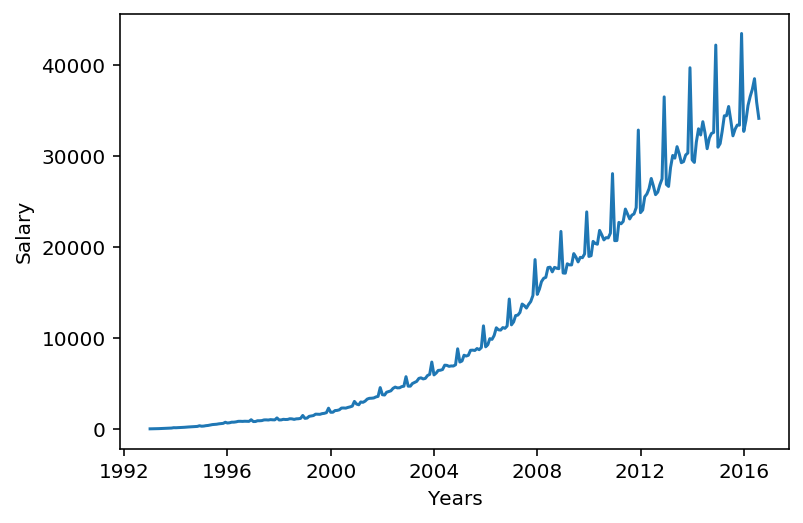

In [3]:
plt.plot(df['zp'])
plt.xlabel('Years')
plt.ylabel('Salary')
plt.show()

Критерий Дики-Фуллера: p=0.991850


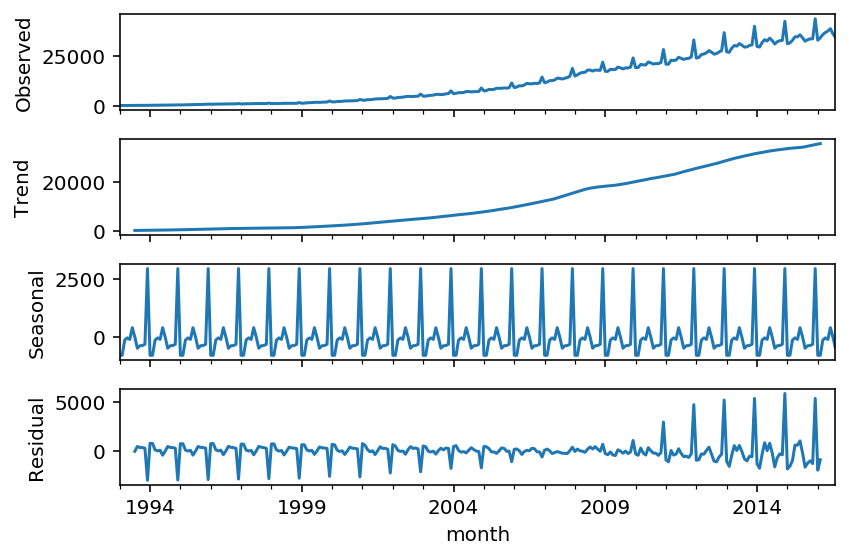

In [4]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(df['zp']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['zp'])[1])

### 2. Стабилизация дисперсии

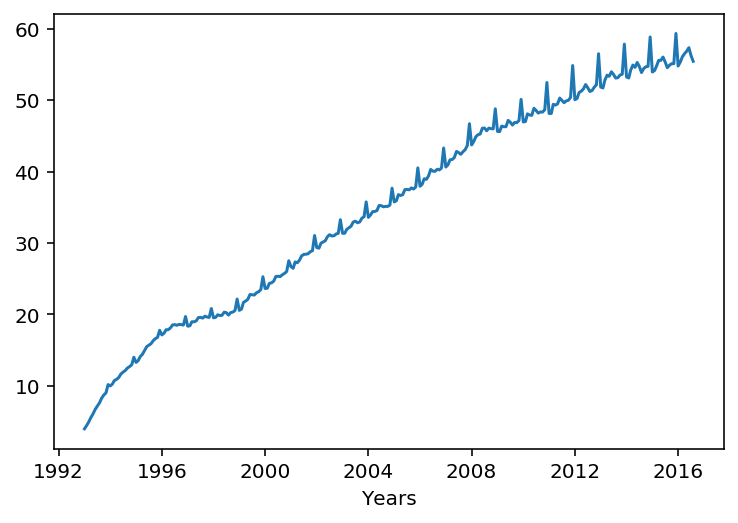

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


In [5]:
from scipy import stats
df['zp_bc'], lmbda = stats.boxcox(df['zp'])
plt.plot(df['zp_bc'])
plt.xlabel('Years')
plt.show()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['zp_bc'])[1])

### 3. Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


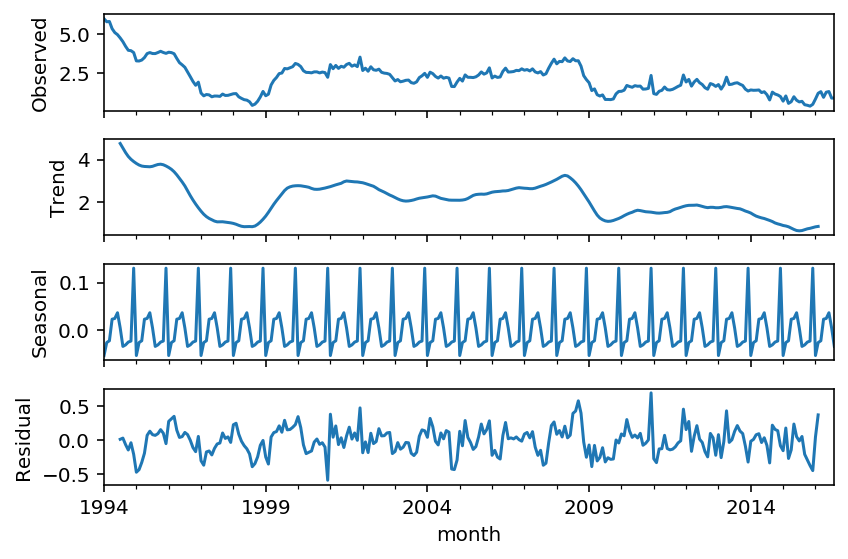

In [6]:
# Сезонное дифференцирование
df['zp_diff'] = df.zp_bc - df.zp_bc.shift(12)
sm.tsa.seasonal_decompose(df['zp_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['zp_diff'][12:])[1])

Критерий Дики-Фуллера: p=0.000000


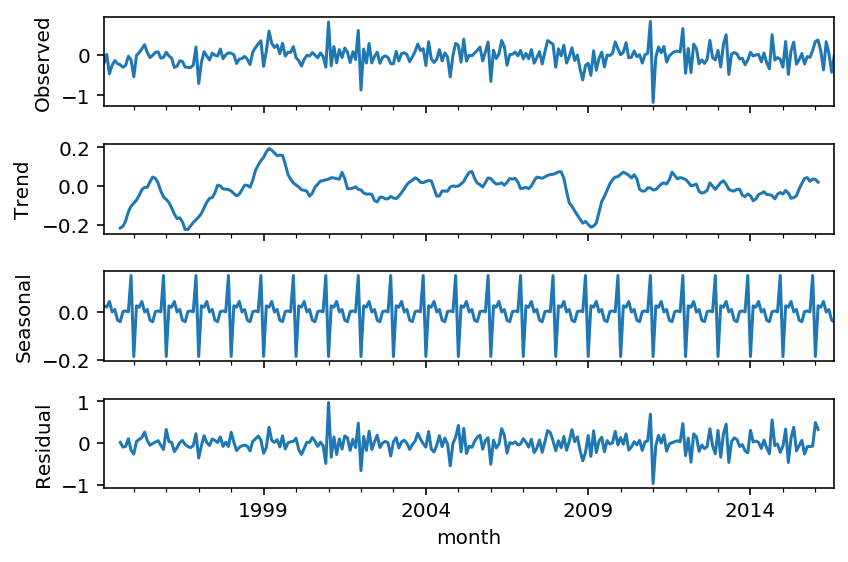

In [7]:
# Обычное дифференцирование
df['zp_diff2'] = df.zp_diff - df.zp_diff.shift(1)
sm.tsa.seasonal_decompose(df['zp_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['zp_diff2'][13:])[1])

### 4. Выбор начальных приближений для p,q,P,Q

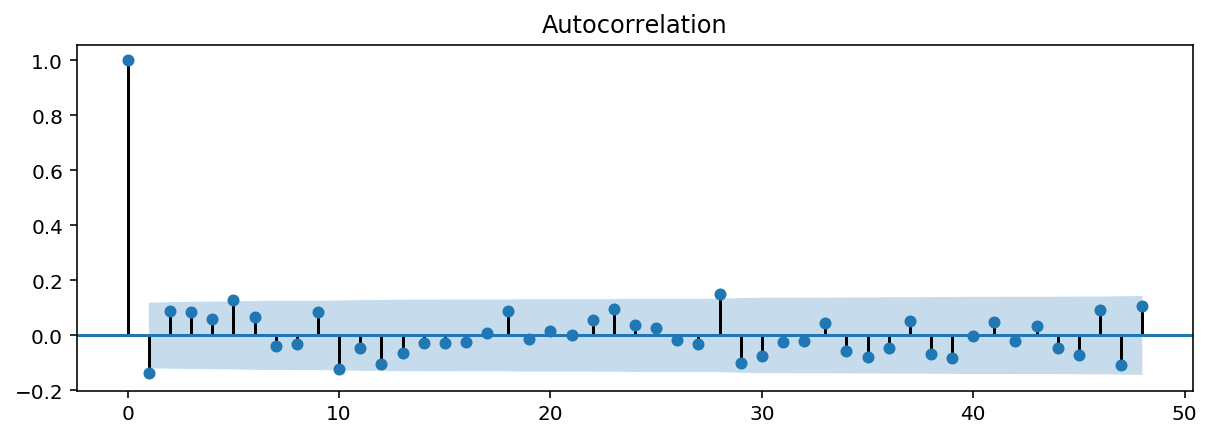

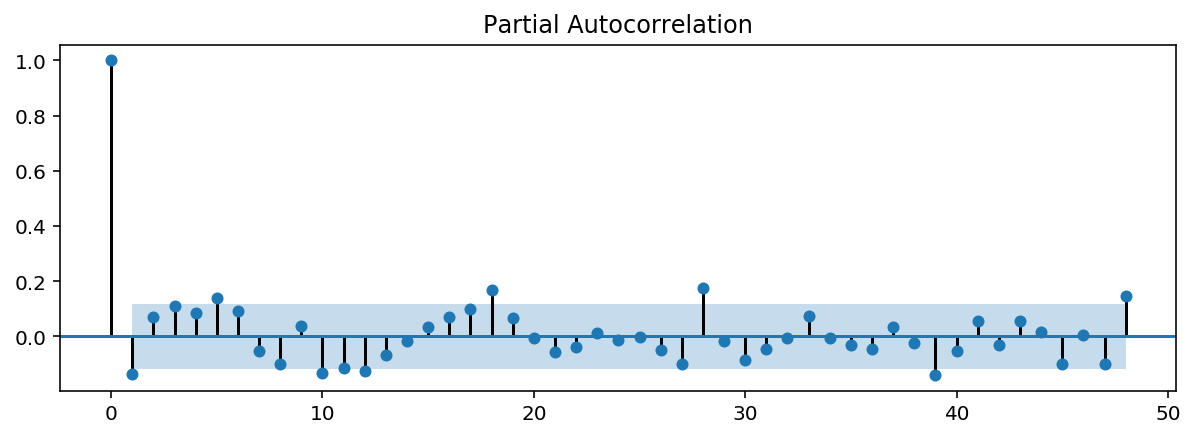

In [8]:
plt.figure(figsize=(10,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['zp_diff2'][13:].values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize=(10,7))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['zp_diff2'][13:].values.squeeze(), lags=48, ax=ax)
plt.show()

In [9]:
# Начальные приближения: Q=0, q=1, P=1, p=5
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [10]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

24


In [11]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.zp_bc, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
CPU times: user 12.5 s, sys: 1.33 s, total: 13.8 s
Wall time: 8.82 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
21  (5, 1, 1, 0) -5.260134
13  (3, 1, 1, 0) -4.995859
19  (5, 0, 1, 0) -4.545934
17  (4, 1, 1, 0) -3.975974
18  (5, 0, 0, 0) -2.104961


In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              zp_bc   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Tue, 29 Dec 2020   AIC                             -5.260
Time:                                    09:44:07   BIC                             23.557
Sample:                                01-01-1993   HQIC                             6.310
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105   

### 6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

Критерий Стьюдента: p=0.296142
Критерий Дики-Фуллера: p=0.000000


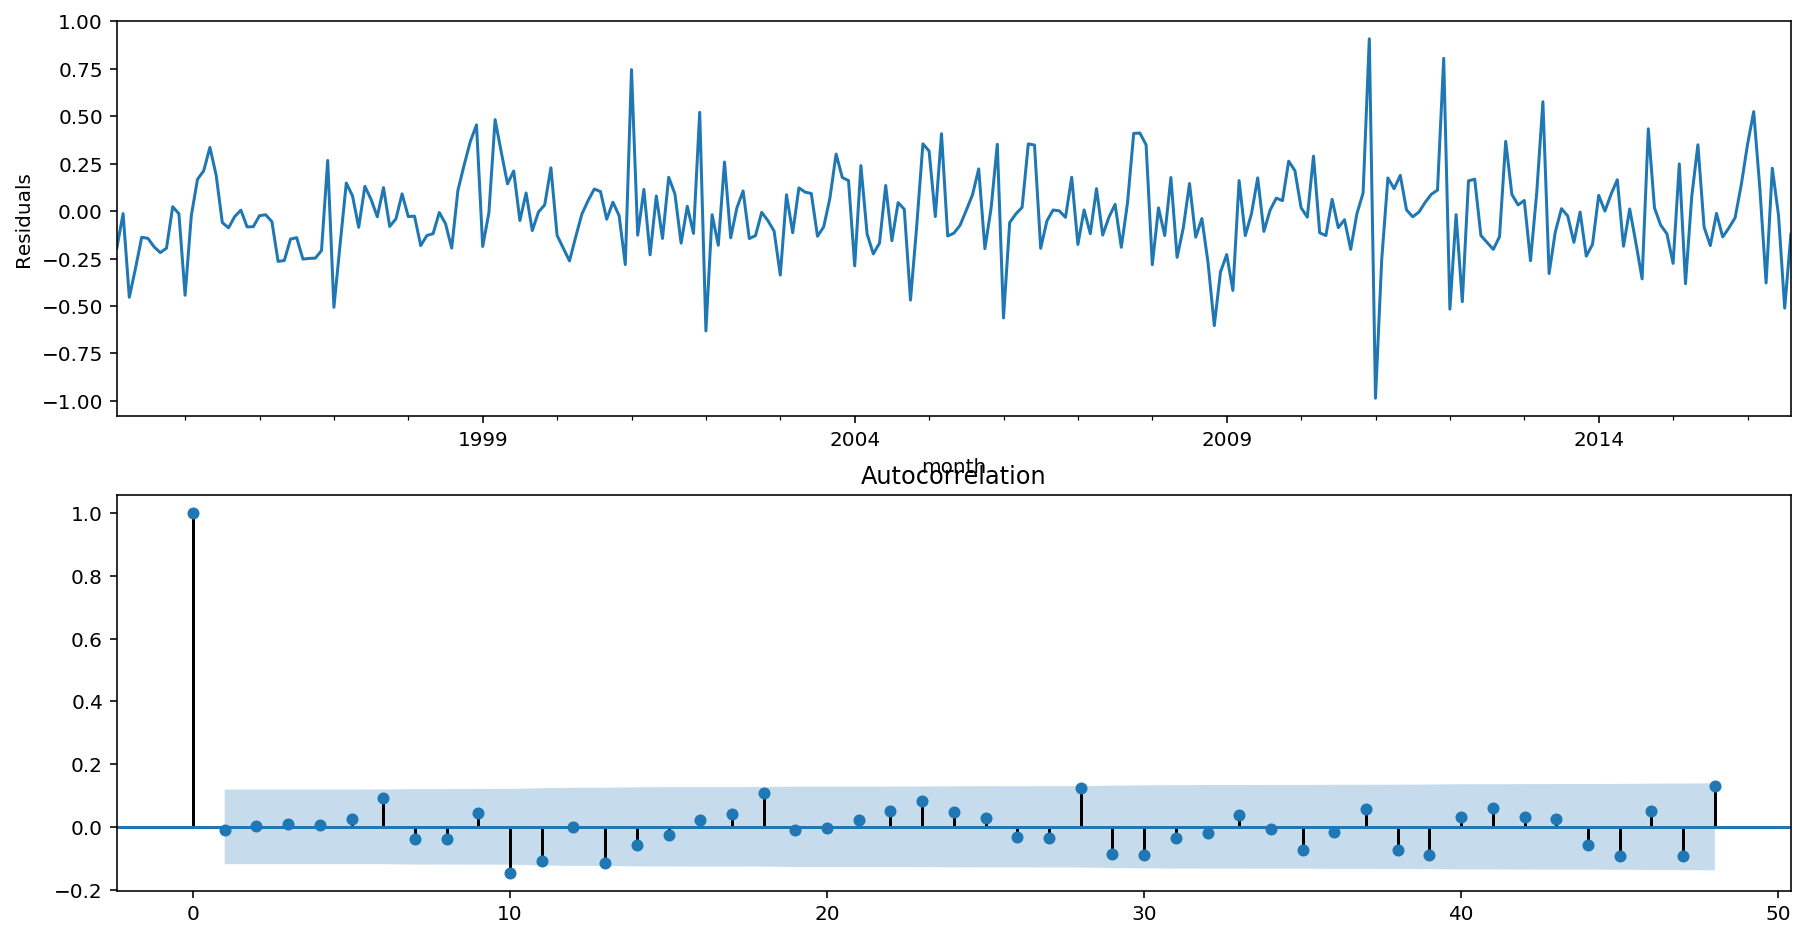

In [14]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

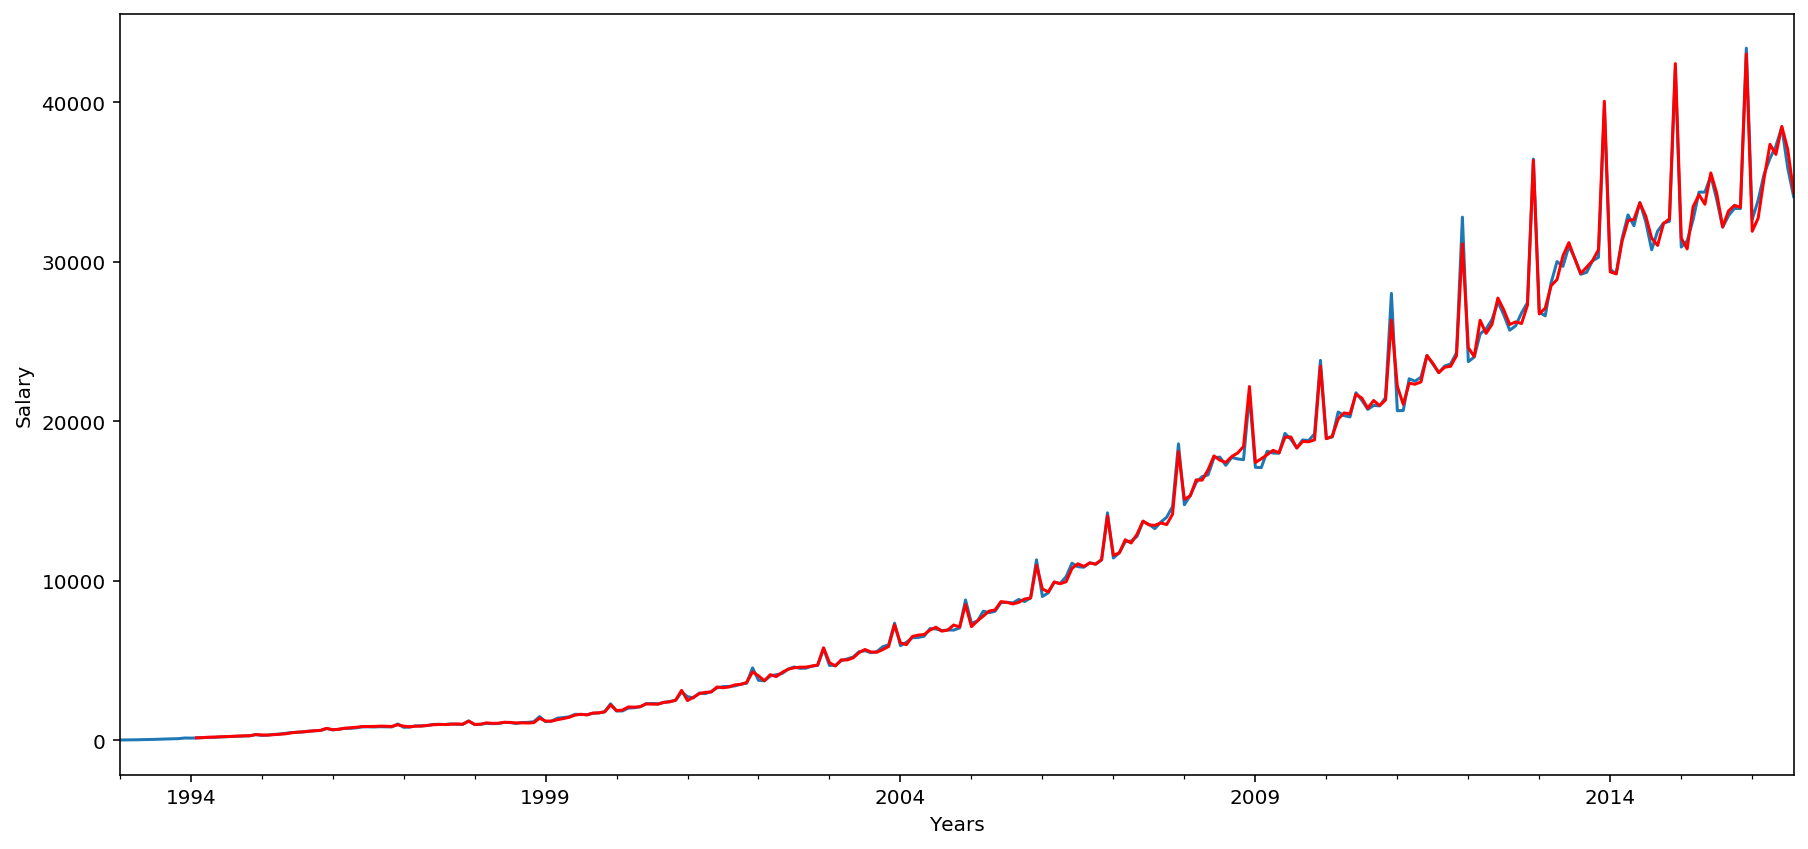

In [15]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df.zp.plot()
df.model[13:].plot(color='r')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.show()

### 7. Прогнозирование с помощью финальной модели.

In [16]:
from time import strptime
from datetime import datetime
from dateutil.relativedelta import relativedelta

df2 = df[['zp']]
number=len(df2['zp'].dropna())
date_list = [datetime(2016,9,1) + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=number, end=number+24), lmbda)
df2.tail(20)

/Users/apple/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


,zp,forecast
2018-01-01,NaN,35762.032119
2018-02-01,NaN,36906.320057
2018-03-01,NaN,38574.774556
2018-04-01,NaN,39723.192978
2018-05-01,NaN,40396.523461
2018-06-01,NaN,41608.408818
2018-07-01,NaN,39017.116226
2018-08-01,NaN,37093.202159
2018-09-01,NaN,37942.075723
2018-10-01,NaN,NaN


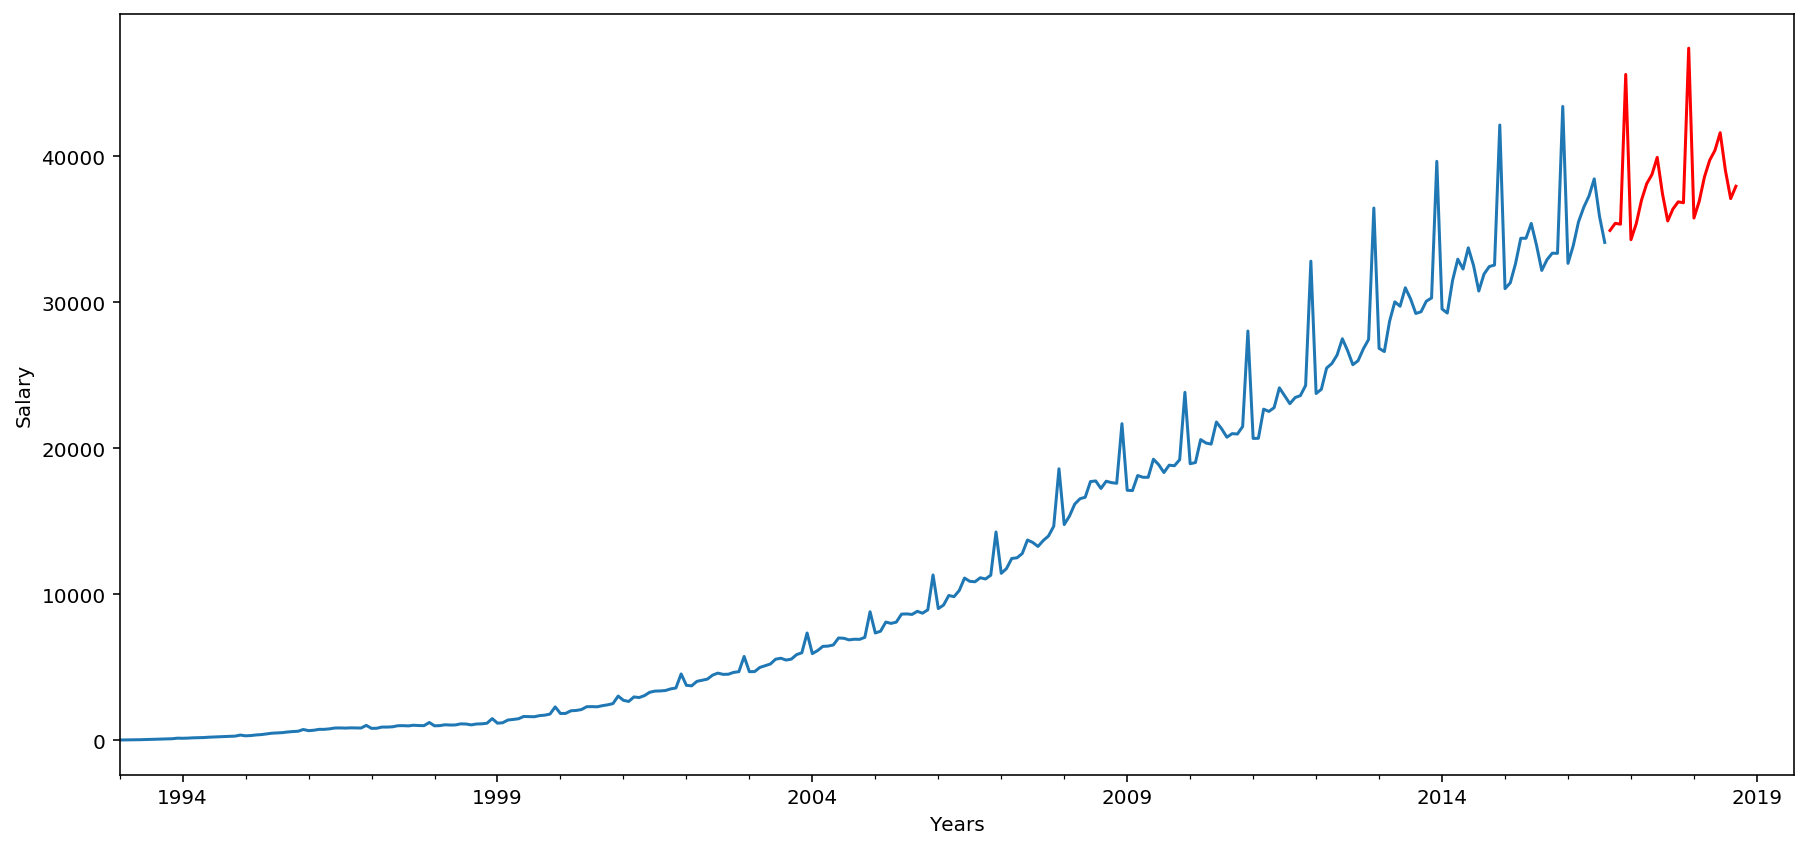

In [17]:
plt.figure(figsize=(15,7))
df2.zp.plot()
df2.forecast.plot(color='r')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.show()